# Ames House Price Predictions

## Initiation and Data Preprocessing

### Import Packages and Files

In [1]:
%%time

## import packages

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE, RFECV, f_regression

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

sns.set_style('darkgrid')
sns.color_palette('Paired')

%matplotlib inline

CPU times: user 916 ms, sys: 177 ms, total: 1.09 s
Wall time: 1.19 s


In [2]:
%%time

## import files

# read files
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

CPU times: user 34.8 ms, sys: 5.17 ms, total: 39.9 ms
Wall time: 38.8 ms


In [3]:
%%time

## defining reusable functions

# create a function to analyze columns

def feature_analysis(dataframe):
    
    # include a column for dtypes of each feature
    feature_analysis_df = pd.DataFrame(dataframe.dtypes)
    feature_analysis_df.columns = ['dtypes']
    
    # include a column for number of unique values of each feature
    feature_analysis_df['nunique'] = 0
    for feat in feature_analysis_df.index:
        feature_analysis_df.loc[feat,'nunique'] = len(dataframe.loc[:,feat].unique())
        
    # include a column for number of unique values of each feature    
    feature_analysis_df['isnull'] = 0
    for feat in feature_analysis_df.index:
        feature_analysis_df.loc[feat,'isnull'] = dataframe.loc[:,feat].isnull().sum(axis = 0)
        
    # print dataset characteristics
    print('\nDataset Characteristics \n')
    print('rows:', dataframe.shape[0])
    print('columns:', dataframe.shape[1])
    print(feature_analysis_df)
    print()
    
    
## a function to calculate rmse for model evaluation

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


### Data Exploration and Cleaning

#### Selecting Useful Variables

In [4]:
## analyze raw dataset features: datatypes, null values, number of unique values
#feature_analysis(df_train_raw)
#df_train.info()

In [5]:
%%time

## analyzing continuous variables

# display continuous variables
# print(df_train_raw.columns[df_train_raw.dtypes == 'int64'])

# isolating continuous variables
df_train_raw_continuous = df_train_raw[list(df_train_raw.columns[df_train_raw.dtypes == 'int64'])]

# checking descriptive statistics
# df_train_raw_continuous.describe().T

# identifying continuous variables with highest correlation to the target
print(df_train_raw_continuous.corr()['SalePrice'].apply(abs).sort_values(ascending=False))


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64
CPU times: user 9.2 ms, sys: 2.69 ms, total: 11.9 ms
Wall 

In [6]:
%%time

## selecting features relevant to this project

# create a function to select columns from the raw data
def preliminary_variable_selection(dataframe):
    
    if 'SalePrice' in dataframe.columns:
        selected_variables = dataframe.loc[
                                       dataframe['SalePrice'].notnull()][[
                                       'OverallQual', 'GrLivArea', 'SalePrice']]
        
    else: #applies to test dataset which doesn't have target variable
        selected_variables = dataframe[['OverallQual', 'GrLivArea']]
        
    return selected_variables

# apply function to raw data
df_train = preliminary_variable_selection(df_train_raw)
df_test = preliminary_variable_selection(df_test_raw)

CPU times: user 3.2 ms, sys: 850 µs, total: 4.05 ms
Wall time: 3.52 ms


In [7]:
%%time

## analyze dataset features: datatypes, null values, number of unique values

feature_analysis(df_train)


Dataset Characteristics 

rows: 1460
columns: 3
            dtypes  nunique  isnull
OverallQual  int64       10       0
GrLivArea    int64      861       0
SalePrice    int64      663       0

CPU times: user 10.1 ms, sys: 2.5 ms, total: 12.6 ms
Wall time: 10.6 ms


In [8]:
%%time

## preparing separate dataframe for plotting training data

df_train_plot = df_train.copy()

CPU times: user 142 µs, sys: 3 µs, total: 145 µs
Wall time: 152 µs


## Exploratory Data Analysis

### Univariate and Bivariate Data Analysis

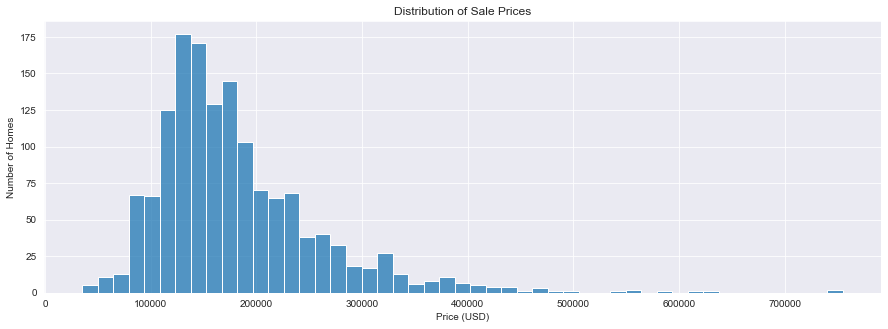

In [9]:

## potting the distribution of the target variable

plt.figure(figsize=(15,5))
ax = sns.histplot(x='SalePrice', data=df_train_plot)
ax.set_title('Distribution of Sale Prices')
ax.set_xlabel('Price (USD)')
ax.set_ylabel('Number of Homes')
plt.show()

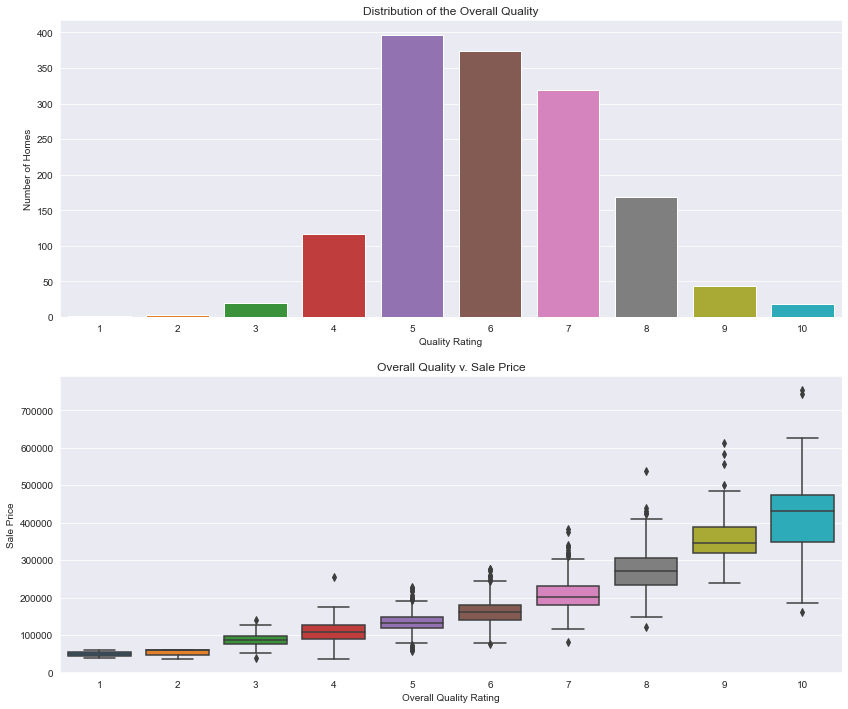

CPU times: user 562 ms, sys: 20.1 ms, total: 583 ms
Wall time: 595 ms


In [10]:
%%time

## potting the distribution of the overall quality and target variables

fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the distribution of the overall quality of the homes
plt.subplot(2, 1, 1)
ax[0] = sns.countplot(x='OverallQual', data=df_train_plot)
ax[0].set_title('Distribution of the Overall Quality')
ax[0].set_xlabel('Quality Rating')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 1, 2)
ax[1] = sns.boxplot(data=df_train_plot, x="OverallQual", y="SalePrice" )
ax[1].set_title('Overall Quality v. Sale Price')
ax[1].set_xlabel('Overall Quality Rating')
ax[1].set_ylabel('Sale Price')

plt.show()

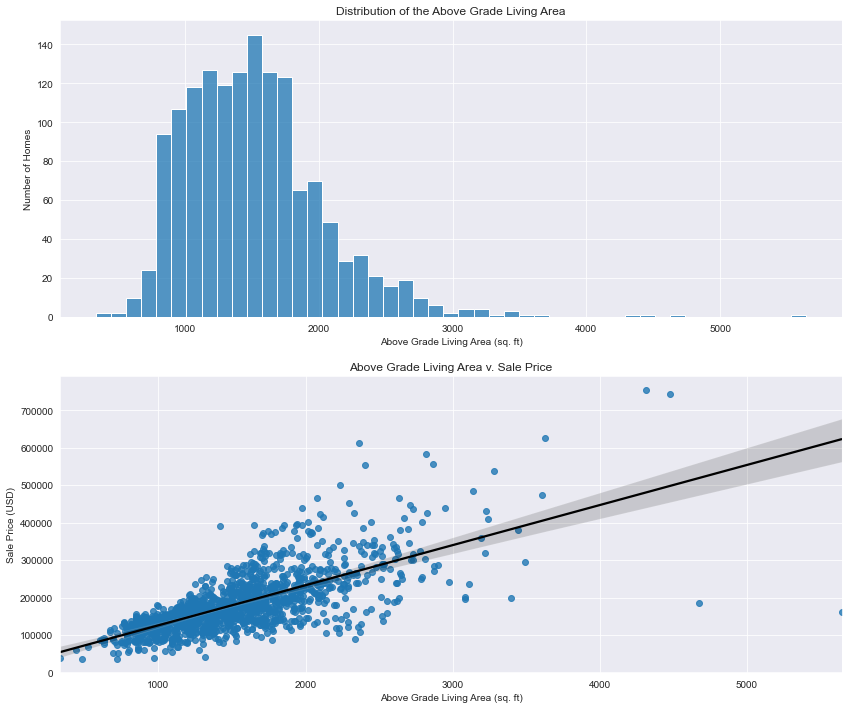

CPU times: user 1.98 s, sys: 53.3 ms, total: 2.04 s
Wall time: 826 ms


In [11]:
%%time

## potting the distribution of the above grade living area and target variables

fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the distribution of the above grade living area of the homes
plt.subplot(2, 1, 1)
ax[0] = sns.histplot(x='GrLivArea', data=df_train_plot)
ax[0].set_title('Distribution of the Above Grade Living Area')
ax[0].set_xlabel('Above Grade Living Area (sq. ft)')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 1, 2)
ax[1] = sns.regplot(data=df_train_plot, x="GrLivArea", y="SalePrice",line_kws={'color':'black'} )
ax[1].set_title('Above Grade Living Area v. Sale Price')
ax[1].set_xlabel('Above Grade Living Area (sq. ft)')
ax[1].set_ylabel('Sale Price (USD)')

plt.show()

In [12]:
df_train_plot['log_overallquall'] = df_train_plot['OverallQual'].apply(math.log)

In [13]:
df_train_plot['log_grlivarea'] = df_train_plot['GrLivArea'].apply(math.log)

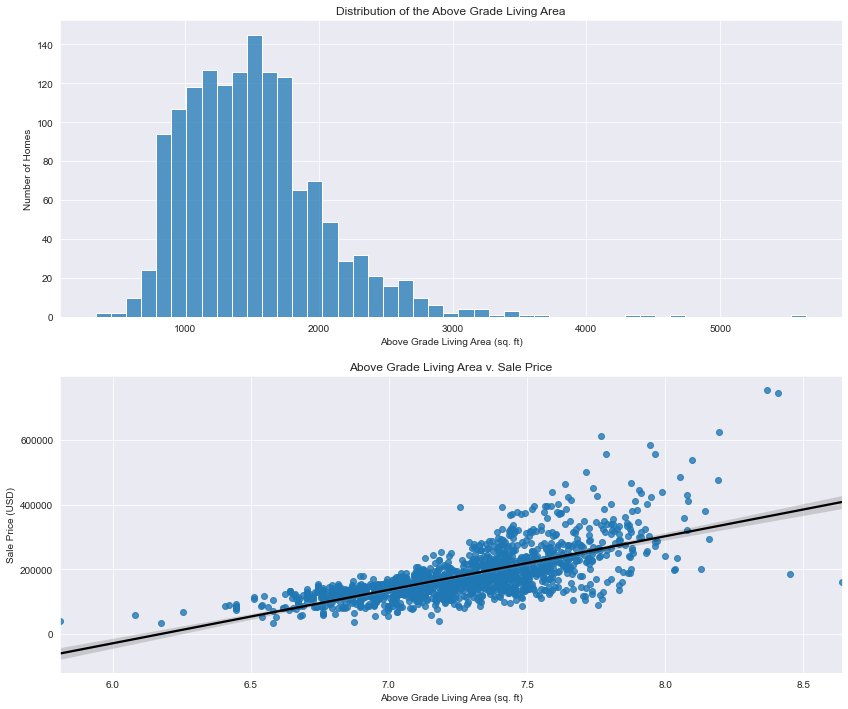

CPU times: user 1.96 s, sys: 57.5 ms, total: 2.02 s
Wall time: 782 ms


In [14]:
%%time

## potting the distribution of the above grade living area and target variables

fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the distribution of the above grade living area of the homes
plt.subplot(2, 1, 1)
ax[0] = sns.histplot(x='GrLivArea', data=df_train_plot)
ax[0].set_title('Distribution of the Above Grade Living Area')
ax[0].set_xlabel('Above Grade Living Area (sq. ft)')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 1, 2)
ax[1] = sns.regplot(data=df_train_plot, x="log_grlivarea", y="SalePrice",line_kws={'color':'black'} )
ax[1].set_title('Above Grade Living Area v. Sale Price')
ax[1].set_xlabel('Above Grade Living Area (sq. ft)')
ax[1].set_ylabel('Sale Price (USD)')

plt.show()

### Multivariate Data Analysis

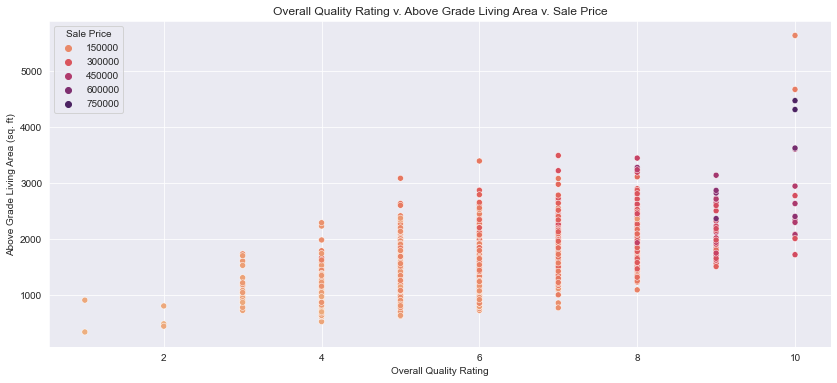

CPU times: user 371 ms, sys: 13 ms, total: 384 ms
Wall time: 383 ms


In [15]:
%%time

## potting the distribution of sales prices in relation to the above ground living area ang overall quality rating

palette = sns.color_palette('flare', as_cmap=True)

fig, ax = plt.subplots(1,1, figsize=(14,6))

ax = sns.scatterplot(
     data=df_train_plot.rename(columns={"SalePrice": "Sale Price"}),
     x="OverallQual", y="GrLivArea", hue='Sale Price', palette=palette )
ax.set_title('Overall Quality Rating v. Above Grade Living Area v. Sale Price')
ax.set_xlabel('Overall Quality Rating')
ax.set_ylabel('Above Grade Living Area (sq. ft)')

plt.show()

### Correlation of Variables

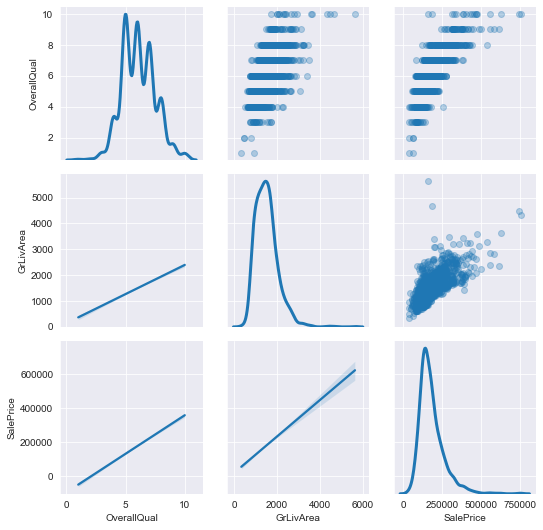

CPU times: user 4.63 s, sys: 82.4 ms, total: 4.72 s
Wall time: 2.12 s


In [16]:
%%time

## Creating Scatterplot Matrix with Sample of Original DataFrame

# Store Samples of DataFrame for Visualization
df_sample = df_train

# Declare Pairgrid
g = sns.PairGrid(df_sample.dropna(), diag_sharey=False)

# Scatterplot
g.map_upper(plt.scatter, alpha=.3)

# Fit Line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# KDE Plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

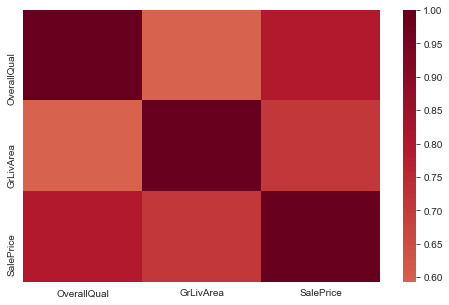

CPU times: user 205 ms, sys: 10.2 ms, total: 216 ms
Wall time: 216 ms


In [17]:
%%time

## Visualizing the Correlatedness of the Session variables

fig, ax = plt.subplots(figsize=(8,5))         
sns.heatmap(df_train.corr(), cmap='RdBu_r', center=0)
plt.show()

### Descriptive Statistics and Boxplots

In [18]:
%%time

## Descriptive Statistics

df_train.describe().T

CPU times: user 9.4 ms, sys: 2.14 ms, total: 11.5 ms
Wall time: 9.51 ms


,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,6.0,7.00,10.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0


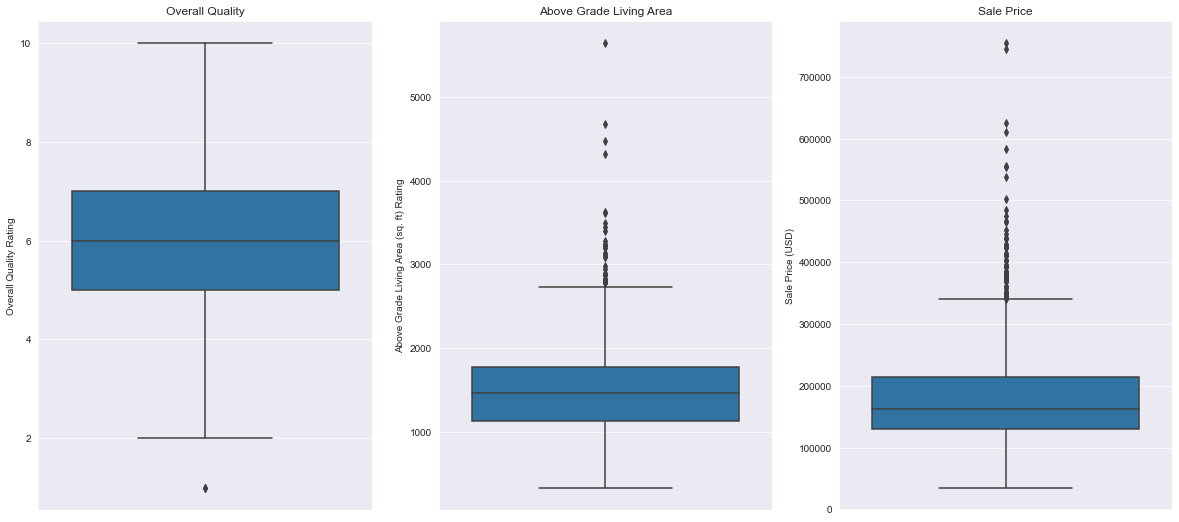

CPU times: user 397 ms, sys: 10.5 ms, total: 407 ms
Wall time: 407 ms


In [19]:
%%time

## potting the distribution of the overall quality and target variables

fig, ax = plt.subplots(1,2, figsize=(15,9))

# potting the distribution of the overall quality of the homes
plt.subplot(1, 3, 1)
ax[0] = sns.boxplot(y='OverallQual', data=df_train_plot)
ax[0].set_title('Overall Quality')
ax[0].set_ylabel('Overall Quality Rating')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(1, 3, 2)
ax[1] = sns.boxplot( y="GrLivArea", data=df_train_plot )
ax[1].set_title('Above Grade Living Area')
ax[1].set_ylabel('Above Grade Living Area (sq. ft) Rating')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(1, 3, 3)
ax[1] = sns.boxplot( y="SalePrice", data=df_train_plot )
ax[1].set_title('Sale Price')
ax[1].set_ylabel('Sale Price (USD)')

plt.subplots_adjust(left=-.15)
plt.show()

## Preparing the Data For Modeling

### Creating Training and Validation Sets

In [77]:
%%time

## Establish Feature and Outcome Variables to be Used for Modeling Based on Original Features

x = df_train.drop('SalePrice',1)
y = df_train['SalePrice']

CPU times: user 830 µs, sys: 459 µs, total: 1.29 ms
Wall time: 1.27 ms


In [98]:
%%time

## Train Test Split the Feature and Outcome Variables

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)

CPU times: user 1.86 ms, sys: 1.62 ms, total: 3.48 ms
Wall time: 2.54 ms


In [99]:

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

### Feature Engineering

In [100]:
x_train.join(y_train).corr()['SalePrice'].apply(abs).sort_values(ascending=False)

SalePrice      1.000000
OverallQual    0.792668
GrLivArea      0.698967
Name: SalePrice, dtype: float64

In [95]:
%%time

###### train and fit model

pipe = Pipeline([('f_engineering', FeatureUnion([('poly', PolynomialFeatures(include_bias=False)),
                                                 ('bins_4', KBinsDiscretizer(n_bins=4, encode='ordinal')),
                                                 ('bins_8', KBinsDiscretizer(n_bins=8, encode='ordinal'))])),
                 ('scaler', StandardScaler()), 
                 ('rfe', RFE(estimator=LinearRegression())), 
                 ('model', LinearRegression())])

pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'rfe__n_features_to_select':[2,3,4,5,6]}).fit(x_train, y_train)



/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

CPU times: user 2.17 s, sys: 55.1 ms, total: 2.23 s
Wall time: 599 ms


/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

In [101]:
# display features
display(pd.DataFrame(columns=pipe.best_estimator_.named_steps['f_engineering'
                                                             ].get_feature_names()
                    ).columns[pipe.best_estimator_.named_steps['rfe'].support_])

AttributeError: Transformer bins_4 (type KBinsDiscretizer) does not provide get_feature_names.

In [76]:
pd.DataFrame(columns=pipe.best_estimator_.named_steps['poly'].get_feature_names(input_features=x_train.columns)
            ).columns[pipe.best_estimator_.named_steps['rfe'].support_]


Index(['OverallQual', 'OverallQual GrLivArea', 'GrLivArea^2'], dtype='object')

In [44]:
%%time

## train and fit model

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('rfe', RFE(estimator=LinearRegression())), 
                 ('model', LinearRegression())])

pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'rfe__n_features_to_select':[1,2,3,4,5,6]}).fit(x_train, y_train)

CPU times: user 1.74 s, sys: 29.9 ms, total: 1.77 s
Wall time: 453 ms


number of features # 2 poly = 25, 3 poly = 46, 4 poly = 71, 5 poly = 101

In [28]:
x_train_features.join(y_train).corr()['SalePrice'].apply(abs).sort_values(ascending=False)

SalePrice                           1.000000
OverallQual GrLivArea               0.819749
OverallQual^2                       0.816187
OverallQual                         0.792668
OverallQual GrLivArea_ord_bins_8    0.777148
OverallQual^2_ord_bins_8            0.756943
OverallQual_ord_bins_8              0.756943
OverallQual GrLivArea_ord_bins_4    0.741765
GrLivArea                           0.698967
OverallQual^2_ord_bins_4            0.672359
OverallQual_ord_bins_4              0.672359
GrLivArea^2_ord_bins_8              0.669745
GrLivArea_ord_bins_8                0.669745
GrLivArea^2_ord_bins_4              0.653533
GrLivArea_ord_bins_4                0.653533
GrLivArea^2                         0.628552
Name: SalePrice, dtype: float64

### Additional Data Cleaning

Removing Extreme Values

## Baseline Modeling and Evaluation

### Linear Regression with Unreduced Features (No PCA)

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

In [29]:
%%time

## finalize data for modeling

x_train = x_train_features
x_val = x_val_features

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


#### Creating and Evaluating the Model 

In [44]:
%%time

## train and fit model

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('rfe', RFE(estimator=LinearRegression())), 
                 ('model', LinearRegression())])

pipe = GridSearchCV(estimator=pipe, 
                    param_grid = {'rfe__n_features_to_select':[1,2,3,4,5,6]}).fit(x_train, y_train)

CPU times: user 1.74 s, sys: 29.9 ms, total: 1.77 s
Wall time: 453 ms


In [55]:
x_train.columns[pipe.best_estimator_.named_steps['rfe'].support_]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 6

In [96]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.7744834447198701

RMSE: 37297.2007482251

MAE: 26288.1078307256



/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

cross validation:
[0.72792221 0.76539254 0.74817349 0.76565938 0.73088585]


CPU times: user 11.2 s, sys: 337 ms, total: 11.5 s
Wall time: 3.12 s


/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consi

In [97]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7796489643168114

RMSE: 38867.93332351001

MAE: 26157.27728314261

CPU times: user 10.4 ms, sys: 2.25 ms, total: 12.7 ms
Wall time: 10.7 ms


In [83]:
display(pd.DataFrame([x_train.columns[pipe.best_estimator_.named_steps['rfe'].support_], 
                      pipe.best_estimator_.named_steps['model'].coef_, 
                      abs(pipe.best_estimator_.named_steps['model'].coef_)]).T.sort_values(2, ascending=False))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 5

### Linear Regression with Features Reduced By PCA

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

In [30]:
%%time

## finalize data for modeling

x_train = x_train_features
x_val = x_val_features

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


#### Creating and Evaluating the Model 

In [31]:
%%time

## train and fit model

pipe = Pipeline([('model', GridSearchCV(estimator = RFE(estimator=LinearRegression()), 
                                        param_grid = {'n_features_to_select':[1,2,3,4,5,6]}))]).fit(x_train, y_train)


CPU times: user 2.94 s, sys: 93 ms, total: 3.03 s
Wall time: 798 ms


In [32]:
x_train.columns[pipe.named_steps['model'].best_estimator_.support_]

Index(['GrLivArea', 'OverallQual GrLivArea', 'GrLivArea^2',
       'OverallQual_ord_bins_4', 'GrLivArea_ord_bins_8',
       'GrLivArea^2_ord_bins_8'],
      dtype='object')

In [33]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.7760453788381951

RMSE: 37167.8155875387

MAE: 25925.78734552723

cross validation:
[0.7364357  0.76576992 0.74637002 0.76320281 0.73088585]


CPU times: user 14.8 s, sys: 597 ms, total: 15.4 s
Wall time: 4.34 s


In [34]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7831388897136669

RMSE: 38558.9091907773

MAE: 25997.42207968799

CPU times: user 5.72 ms, sys: 1.37 ms, total: 7.08 ms
Wall time: 6.25 ms


In [35]:
display(pd.DataFrame([x_train.columns[pipe.named_steps['model'].best_estimator_.support_], 
                      pipe.named_steps['model'].best_estimator_.estimator_.coef_, 
                      abs(pipe.named_steps['model'].best_estimator_.estimator_.coef_)]).T.sort_values(2, ascending=False))

,0,1,2
1,OverallQual GrLivArea,142219,142219
2,GrLivArea^2,-115634,115634
0,GrLivArea,63878.8,63878.8
3,OverallQual_ord_bins_4,-17038.4,17038.4
5,GrLivArea^2_ord_bins_8,-12053.3,12053.3
4,GrLivArea_ord_bins_8,-12053.3,12053.3


## Intermediate Modeling and Evaluation

## Final Modeling and Evaluation

### Linear Regression

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

In [30]:
%%time

## finalize data for modeling

x_train = x_train_features
x_val = x_val_features

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


#### Creating and Evaluating the Model 

In [31]:
%%time

## train and fit model

pipe = Pipeline([('model', GridSearchCV(estimator = RFE(estimator=LinearRegression()), 
                                        param_grid = {'n_features_to_select':[1,2,3,4,5,6]}))]).fit(x_train, y_train)


CPU times: user 2.94 s, sys: 93 ms, total: 3.03 s
Wall time: 798 ms


In [32]:
x_train.columns[pipe.named_steps['model'].best_estimator_.support_]

Index(['GrLivArea', 'OverallQual GrLivArea', 'GrLivArea^2',
       'OverallQual_ord_bins_4', 'GrLivArea_ord_bins_8',
       'GrLivArea^2_ord_bins_8'],
      dtype='object')

In [33]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.7760453788381951

RMSE: 37167.8155875387

MAE: 25925.78734552723

cross validation:
[0.7364357  0.76576992 0.74637002 0.76320281 0.73088585]


CPU times: user 14.8 s, sys: 597 ms, total: 15.4 s
Wall time: 4.34 s


In [34]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7831388897136669

RMSE: 38558.9091907773

MAE: 25997.42207968799

CPU times: user 5.72 ms, sys: 1.37 ms, total: 7.08 ms
Wall time: 6.25 ms


In [35]:
display(pd.DataFrame([x_train.columns[pipe.named_steps['model'].best_estimator_.support_], 
                      pipe.named_steps['model'].best_estimator_.estimator_.coef_, 
                      abs(pipe.named_steps['model'].best_estimator_.estimator_.coef_)]).T.sort_values(2, ascending=False))

,0,1,2
1,OverallQual GrLivArea,142219,142219
2,GrLivArea^2,-115634,115634
0,GrLivArea,63878.8,63878.8
3,OverallQual_ord_bins_4,-17038.4,17038.4
5,GrLivArea^2_ord_bins_8,-12053.3,12053.3
4,GrLivArea_ord_bins_8,-12053.3,12053.3


### Decision Tree

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

In [122]:
%%time

## select features through recursive feature elimination

estimator = DecisionTreeRegressor()      
rfe = RFECV(estimator=estimator, step=1, scoring='neg_root_mean_squared_error')
rfe = rfe.fit(x_train_features, y_train)

print('Chosen best features by rfe:',x_train_features.columns[rfe.support_])

Chosen best features by rfe: Index(['OverallQual', 'GrLivArea', 'OverallQual^2', 'OverallQual GrLivArea',
       'GrLivArea^2', 'OverallQual_ord_bins_3', 'GrLivArea_ord_bins_3',
       'OverallQual_ord_bins_4', 'GrLivArea_ord_bins_4',
       'OverallQual_ord_bins_8', 'GrLivArea_ord_bins_8',
       'OverallQual^2_ord_bins_8', 'OverallQual GrLivArea_ord_bins_8',
       'GrLivArea^2_ord_bins_8'],
      dtype='object')
CPU times: user 619 ms, sys: 5.73 ms, total: 625 ms
Wall time: 626 ms


In [125]:
%%time

## finalize data for modeling

x_train = x_train_features[x_train_features.columns[rfe.support_]]
x_val = x_val_features[x_train_features.columns[rfe.support_]]

CPU times: user 1.23 ms, sys: 59 µs, total: 1.29 ms
Wall time: 1.24 ms


#### Creating and Evaluating the Model 

In [154]:
%%time

## train and fit model

pipe = Pipeline([('decision_tree', DecisionTreeRegressor())]).fit(x_train, y_train)

CPU times: user 6.84 ms, sys: 1.2 ms, total: 8.03 ms
Wall time: 6.62 ms


In [155]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.980399832671382

RMSE: 10995.548867468751

MAE: 4017.0228514350943

cross validation:
[0.43505117 0.45622342 0.67204978 0.50788886 0.59578102]


CPU times: user 42.9 ms, sys: 2.26 ms, total: 45.2 ms
Wall time: 43.4 ms


In [156]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7083686894013014

RMSE: 44714.767382501144

MAE: 32899.71020874103

CPU times: user 4.98 ms, sys: 1.3 ms, total: 6.28 ms
Wall time: 5.05 ms


In [158]:

display(pd.DataFrame([x_train.columns, 
                      pipe.named_steps['decision_tree'].feature_importances_, 
                      abs(
                      pipe.named_steps['decision_tree'].feature_importances_)]).T.sort_values(2, 
                      ascending=False))


,0,1,2
3,OverallQual GrLivArea,0.794685,0.794685
1,GrLivArea,0.076219,0.076219
4,GrLivArea^2,0.0713745,0.0713745
2,OverallQual^2,0.0268849,0.0268849
18,OverallQual_ord_bins_8,0.0205685,0.0205685
0,OverallQual,0.00357697,0.00357697
10,OverallQual^2_ord_bins_3,0.00243763,0.00243763
12,GrLivArea^2_ord_bins_3,0.0010112,0.0010112
21,OverallQual GrLivArea_ord_bins_8,0.000632305,0.000632305
6,OverallQual^2_ord_bins_2,0.000593267,0.000593267


### Random Forest

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

In [130]:
%%time

## select features through recursive feature elimination

estimator = RandomForestRegressor()      
rfe = RFECV(estimator=estimator, step=1, scoring='neg_root_mean_squared_error')
rfe = rfe.fit(x_train_features, y_train)

print('Chosen best features by rfe:',x_train_features.columns[rfe.support_])

Chosen best features by rfe: Index(['OverallQual', 'GrLivArea', 'OverallQual^2', 'OverallQual GrLivArea',
       'GrLivArea^2', 'OverallQual_ord_bins_2', 'OverallQual^2_ord_bins_2',
       'GrLivArea^2_ord_bins_2', 'OverallQual_ord_bins_3',
       'GrLivArea_ord_bins_3', 'OverallQual^2_ord_bins_3',
       'OverallQual GrLivArea_ord_bins_3', 'GrLivArea^2_ord_bins_3',
       'OverallQual_ord_bins_4', 'GrLivArea_ord_bins_4',
       'OverallQual^2_ord_bins_4', 'OverallQual GrLivArea_ord_bins_4',
       'GrLivArea^2_ord_bins_4', 'OverallQual_ord_bins_8',
       'GrLivArea_ord_bins_8', 'OverallQual^2_ord_bins_8',
       'OverallQual GrLivArea_ord_bins_8', 'GrLivArea^2_ord_bins_8'],
      dtype='object')
CPU times: user 47 s, sys: 894 ms, total: 47.9 s
Wall time: 48.2 s


In [131]:
%%time

## finalize data for modeling

x_train = x_train_features[x_train_features.columns[rfe.support_]]
x_val = x_val_features[x_train_features.columns[rfe.support_]]

CPU times: user 1.4 ms, sys: 172 µs, total: 1.57 ms
Wall time: 1.52 ms


#### Creating and Evaluating the Model 

In [132]:
%%time

## train and fit model

rfr = RandomForestRegressor().fit(x_train, y_train)

CPU times: user 471 ms, sys: 10.2 ms, total: 481 ms
Wall time: 482 ms


In [159]:
%%time

## train and fit model

pipe = Pipeline([('rfr', RandomForestRegressor())]).fit(x_train, y_train)

CPU times: user 444 ms, sys: 10.8 ms, total: 455 ms
Wall time: 455 ms


In [160]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, pipe.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(pipe, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.9399872485601349

RMSE: 19240.165029678275

MAE: 12532.602947907022

cross validation:
[0.62926585 0.6308882  0.73751701 0.68574998 0.70282681]


CPU times: user 2.04 s, sys: 37.8 ms, total: 2.08 s
Wall time: 2.08 s


In [161]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(pipe.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(pipe.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, pipe.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7815967981255885

RMSE: 38695.76184427969

MAE: 28368.9487498393

CPU times: user 40 ms, sys: 1.93 ms, total: 42 ms
Wall time: 40.3 ms


In [162]:

display(pd.DataFrame([x_train.columns, 
                      pipe.named_steps['rfr'].feature_importances_, 
                      abs(
                      pipe.named_steps['rfr'].feature_importances_)]).T.sort_values(2, 
                      ascending=False))


,0,1,2
3,OverallQual GrLivArea,0.778714,0.778714
4,GrLivArea^2,0.0632569,0.0632569
1,GrLivArea,0.0613122,0.0613122
0,OverallQual,0.0334247,0.0334247
2,OverallQual^2,0.0318997,0.0318997
18,OverallQual_ord_bins_8,0.0112891,0.0112891
20,OverallQual^2_ord_bins_8,0.00847327,0.00847327
15,OverallQual^2_ord_bins_4,0.00213399,0.00213399
13,OverallQual_ord_bins_4,0.00160974,0.00160974
22,GrLivArea^2_ord_bins_8,0.00156669,0.00156669


## Creating Price Predictions For Unsold Homes

select/establish best model for efficiency

select/establish best model for accuracy

Apply Models

Create histograms

Write about strengths and weaknesses

## Final Analysis and Conclusion

### Analysis of Feature Importance

### Conclusion and Discussion

## Next Steps

** baseline model plan: 2 top continuous features with automated feature engineering, 2 versions of model (pca and non pca) **

remove constant from polynomial

attempt feature union

make everything pipelines/ merge multiple datasets within pipeline
https://stackoverflow.com/questions/36113686/multiple-pipelines-that-merge-within-a-sklearn-pipeline

make baseline linear model with no pca so features can be observed

make baseline model with pca so max accuracy can be attained

Log and e transformations

look into feature importances after pca
https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis


add correlation lists wherever necessary

clean notebook and use baseline models on test set

r2 v rmse for model tuning

select k best v rfe

use baseline models on test set

Make feature graphic like in
https://stackoverflow.com/questions/36113686/multiple-pipelines-that-merge-within-a-sklearn-pipeline

Writeup and establish project for baseline modeling

** baseline model established **

Model task sections (implementing extra features, categorical features, choosing model type, etc.)

** 2 continuous feature linear baseline models, additional methods**

use RFE and RFECV for feature selection (compare then just use rfecv)

** 2 continuous feature linear baseline models, engineering categorical features**

original ordinal features to make strings

make strings from engineered bins

Sklearn binarize continuous features at different thresholds


** max possible continuous features **

implement and scale max possible continuous features

consider pca after feature selection

** implement categorical features from original dataset

test set eveluation and visualization

## Resources